In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba

In [2]:
infile = "data/signal/wza_UL18.root" # --signal
#infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root' # --data 
#infile = 'data/data/CA42F3A2-614F-4A4F-AF18-F6E66CDA2C85_skim_2ElIdPt20.root'
#infile = 'data/Ntuple/EGamma_Run2018B.root'
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root" # --mc


year='2018'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',    # Recomended
        ]
    }

In [5]:
# << flat dim helper function >>
def flat_dim(arr):

#   if len(ak.to_numpy(arr).shape) > 1:
#       sub_arr = ak.flatten(arr)
#   else:
#       sub_arr = arr
    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])
# << drop na helper function >>
def drop_na(arr):

    mask = ~ak.is_none(arr)

    return arr[mask]
# << drop na helper function >>
def drop_na_np(arr):

    mask = ~np.isnan(arr)

    return arr[mask]
# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [6]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

Initial_events = events
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

cut1 = np.ones(len(events))
# Particle Identification
Electron = events.Electron
Photon = events.Photon
MET = events.MET


In [7]:
def Particle_selection(ele,pho):
    # Electron selection
    #EleSelmask = ((ele.pt > 25) & (np.abs(ele.eta + ele.deltaEtaSC) < 1.4442) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1)) | \


    EleSelmask = EleSelmask = ((ele.pt > 10) & (np.abs(ele.eta + ele.deltaEtaSC) < 1.4442) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1)) | \
        ((ele.pt > 10) & (np.abs(ele.eta + ele.deltaEtaSC) > 1.5660) & (np.abs(ele.eta + ele.deltaEtaSC) < 2.5) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.1) & (abs(ele.dz) < 0.2))



    # -SEN-
    #EleSelmask = ((ele.pt > 25) & (np.abs(ele.eta + ele.deltaEtaSC) < 1.479) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1)) | \
    #                ((ele.pt > 25) & (np.abs(ele.eta + ele.deltaEtaSC) > 1.479) & (np.abs(ele.eta + ele.deltaEtaSC) < 2.5) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.1) & (abs(ele.dz) < 0.2))




    # Photon selection
    isgap_mask = (abs(pho.eta) < 1.442)  |  ((abs(pho.eta) > 1.566) & (abs(pho.eta) < 2.5))
    Pixel_seed_mask = ~pho.pixelSeed



    isPrompt = (Photon.genPartFlav == 1) | (Photon.genPartFlav == 11)
    PhoSelmask = (pho.pt > 20) & (pho.cutBased > 1) & isgap_mask &  Pixel_seed_mask & isPrompt



    return EleSelmask,PhoSelmask

In [8]:
# Event Selection   --> 3 Electrons 1 or more photon  
Electron_mask, Photon_mask  = Particle_selection(Electron,Photon)
Ele_channel_mask = ak.num(Electron[Electron_mask])  == 3
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0

Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]

In [9]:
# Particle array
Electron = Ele_channel_events.Electron
Photon  = Ele_channel_events.Photon
Jet     = Ele_channel_events.Jet
nPV      = Ele_channel_events.PV.npvsGood
MET      = Ele_channel_events.MET

In [10]:
Electron_mask,Photon_mask = Particle_selection(Electron,Photon)
Electron = Electron[Electron_mask]
Photon  = Photon[Photon_mask]

In [11]:
##-----------  Cut flow3: Electron Selection --> OSSF 
# OSSF index maker
@numba.njit
def find_3lep(events_leptons,builder):
    for leptons in events_leptons:

        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0+1,nlep):
                if leptons[i0].charge + leptons[i1].charge != 0: continue;

                for i2 in range(nlep):
                    if len({i0,i1,i2}) < 3: continue;
                    builder.begin_tuple(3)
                    builder.index(0).integer(i0)
                    builder.index(1).integer(i1)
                    builder.index(2).integer(i2)
                    builder.end_tuple()
        builder.end_list()
    return builder

eee_triplet_idx = find_3lep(Electron,ak.ArrayBuilder()).snapshot()

# OSSF cut
ossf_mask = ak.num(eee_triplet_idx) == 2
eee_triplet_idx = eee_triplet_idx[ossf_mask]
Electron= Electron[ossf_mask]
Photon= Photon[ossf_mask]
Jet= Jet[ossf_mask]
MET = MET[ossf_mask]

In [12]:
Triple_electron = [Electron[eee_triplet_idx[idx]] for idx in "012"]
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
    {
                "x":vec.x,
                "y":vec.y,
                "z":vec.z,
                "t":vec.t
    },
    with_name = "LorentzVector"
    )
    return vec

def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
    {
         "pt": vec.pt,
         "eta": vec.eta,
         "phi": vec.phi,
         "mass": vec.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
    )

    return vec



Triple_eee = ak.zip({"lep1":Triple_electron[0],
                            "lep2":Triple_electron[1],
                         "lep3":Triple_electron[2],
                         "p4":TLorentz_vector(Triple_electron[0]+Triple_electron[1])})


In [13]:
bestZ_idx = ak.singletons(ak.argmin(abs(Triple_eee.p4.mass - 91.1876), axis=1))
Triple_eee = Triple_eee[bestZ_idx]
leading_ele, subleading_ele, Third_ele = ak.flatten(TLorentz_vector_cylinder(Triple_eee.lep1)),ak.flatten(TLorentz_vector_cylinder(Triple_eee.lep2)),ak.flatten(TLorentz_vector_cylinder(Triple_eee.lep3))

In [14]:
##-----------  Cut flow4: Photon "cleaning"  -- Basis of array-dimension
def make_DR(ele1,ele2,ele3,pho,jet):

    dR_e1pho  = ele1.delta_r(pho) # dR pho,ele1
    dR_e2pho  = ele2.delta_r(pho) # dR pho,ele2
    dR_e3pho  = ele3.delta_r(pho) # dR pho,ele3
    dR_phojet = jet[:,0].delta_r(pho) # dR pho,jet # #--> Need check

    #dR_mask    = (dR_e1pho > 0.4) & (dR_e2pho > 0.4)&  (dR_e3pho > 0.4) & (dR_phojet > 0.4) #--> Need check
    dR_mask = (dR_e1pho > 0.4) & (dR_e2pho > 0.4)&  (dR_e3pho > 0.4)

    #return dR_mask,dR_e1pho,dR_e2pho,dR_e3pho,dR_phojet #--> Need check
    return dR_mask,dR_e1pho,dR_e2pho,dR_e3pho,dR_phojet

#dR_mask,dR_e1pho,dR_e2pho,dR_e3pho,dR_phojet = make_DR(leading_ele,subleading_ele,Third_ele,Photon,Jet) #--> Need check
dR_mask,dR_e1pho,dR_e2pho,dR_e3pho,dR_phojet  = make_DR(leading_ele,subleading_ele,Third_ele,Photon,Jet)
Photon = Photon[dR_mask]


Ele_channel_with_dR = Ele_channel_events[ak.num(Photon) > 0]
Triple_eee = Triple_eee[ak.num(Photon) > 0]
Jet     = Jet[ak.num(Photon) > 0]
nPV = nPV[ak.num(Photon) > 0]

MET = MET[ak.num(Photon) > 0]

Photon  = Photon[ak.num(Photon) > 0] # Beware the order! Photon must be located last!

dR_phojet = flat_dim(Jet[:,0].delta_r(Photon))

In [15]:
def make_leading_pair(target,base):
    return target[ak.argmax(base.pt,axis=1,keepdims=True)]

leading_pho     = make_leading_pair(Photon,Photon)

In [16]:
# bjet veto
bJet_selmask = (Jet.btagCMVA > -0.5844)
bJet_veto    = ak.num(Jet[bJet_selmask])==0
cut5 = np.ones(ak.sum(ak.num(leading_pho[bJet_veto] > 0 ))) * 5


# Z mass window
diele             = Triple_eee.p4
zmass_window_mask = ak.firsts((diele.mass) > 60 | (diele.mass < 120)) # signal region
#zmass_window_mask = ak.firsts(diele.mass) > 4  # control region


# M(eea) cuts 
eeg_vec           = diele + leading_pho
Meeg_mask         = ak.firsts(eeg_vec.mass > 120)

# Electron PT cuts
Elept_mask = ak.firsts((Triple_eee.lep1.pt > 25) & (Triple_eee.lep2.pt > 10) & (Triple_eee.lep3.pt > 25))

# MET cuts
MET_mask = MET.pt > 20

# Mask
Event_sel_mask   = bJet_veto & zmass_window_mask & Meeg_mask & Elept_mask & MET_mask # SR
#Event_sel_mask  = bJet_veto & zmass_window_mask & Meeg_mask & Elept_mask & MET_mask  & Loose_muon_veto_mask # SR (beta)
#Event_sel_mask  = bJet_veto & zmass_window_mask & Elept_mask & MET_mask   # CL


# Apply cyts
Triple_eee_sel   = Triple_eee[Event_sel_mask]
leading_pho_sel   = leading_pho[Event_sel_mask]
# Photon  EE and EB
isEE_mask = leading_pho.isScEtaEE
isEB_mask = leading_pho.isScEtaEB
Pho_EE = leading_pho[isEE_mask & Event_sel_mask]
Pho_EB = leading_pho[isEB_mask & Event_sel_mask]
MET_sel           = MET[Event_sel_mask]

In [23]:
leading_ele, subleading_ele, Third_ele = ak.flatten(TLorentz_vector_cylinder(Triple_eee_sel.lep1)),ak.flatten(TLorentz_vector_cylinder(Triple_eee_sel.lep2)),ak.flatten(TLorentz_vector_cylinder(Triple_eee_sel.lep3))

In [27]:
dPhi_ewMET = Third_ele.delta_phi(MET_sel)

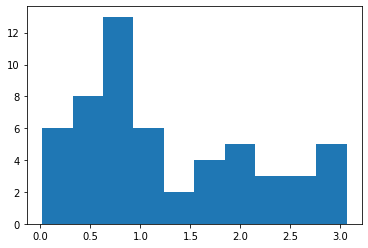

In [31]:
plt.hist(abs(dPhi_ewMET),bins=10)
plt.show()

In [44]:
abs(dPhi_ewMET) 

<Array [0.492, 0.39, 2.92, ... 1.78, 0.669] type='55 * ?float32'>

In [41]:
import math
def make_dphi(MET,ele):
    dphi = abs(MET - ele)
    if dphi > math.pi:
        return 2*math.pi - dphi
    else:
        return dphi

In [42]:
make_dphi_vec = np.vectorize(make_dphi)

In [43]:
make_dphi_vec(MET_sel.phi,Third_ele.phi)

array([0.49169922, 0.39013672, 2.9247868 , 2.605957  , 1.1669922 ,
       3.0336735 , 1.9764404 , 0.7739258 , 2.1394043 , 0.8532562 ,
       0.29492188, 0.01806641, 0.57666016, 1.9120916 , 2.3310368 ,
       1.4040527 , 0.06689453, 0.95410156, 0.6225586 , 0.20239258,
       0.69454956, 2.918457  , 2.5947876 , 1.8942261 , 0.32421875,
       2.2519352 , 0.6713867 , 1.4780273 , 0.8642578 , 3.0527344 ,
       2.0493164 , 0.90185547, 0.04049158, 0.4248047 , 3.0606816 ,
       1.0520172 , 0.4086914 , 0.7078705 , 0.95945483, 2.7333806 ,
       0.807251  , 0.6796697 , 0.54956055, 1.2094727 , 0.791626  ,
       0.9472656 , 1.7423096 , 1.7834473 , 2.1762695 , 0.88238525,
       1.7660828 , 0.05322266, 0.88049316, 1.7808838 , 0.6689275 ],
      dtype=float32)

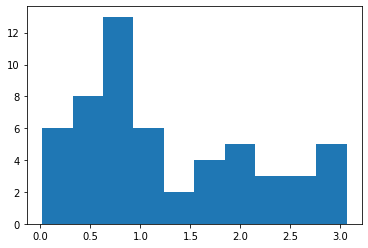

In [45]:
plt.hist(make_dphi_vec(MET_sel.phi,Third_ele.phi),bins=10)
plt.show()

In [48]:
reverse = abs(MET_sel.delta_phi(Third_ele))

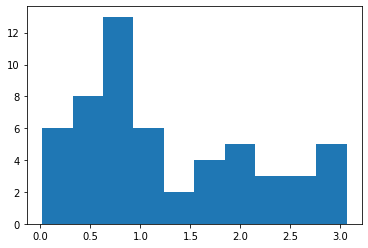

In [49]:
plt.hist(reverse,bins=10)
plt.show()